CUSTOMER RISK SCORING MODEL - CREDIT CARD CUSTOMER ASSESSMENT


STEP 1: Generating Synthetic Dataset...
--------------------------------------------------------------------------------
✓ Generated 1000 customer records
✓ Features: 13 columns
✓ Added 50 missing values for cleaning demo
✓ Added 10 outliers for cleaning demo

Dataset Preview:
  customer_id  age      income employment_status  dependents  credit_limit  \
0   CUST00001   59   7500000.0          Employed           3      10000000   
1   CUST00002   49   3000000.0          Employed           3       5000000   
2   CUST00003   35  20000000.0          Employed           2      15000000   
3   CUST00004   63   7500000.0          Employed           2       5000000   
4   CUST00005   28   5000000.0          Employed           0      10000000   

   credit_utilization  avg_monthly_spending  late_payment_count  \
0           17.592434               1759243                   1   
1           31.647010               1582350            

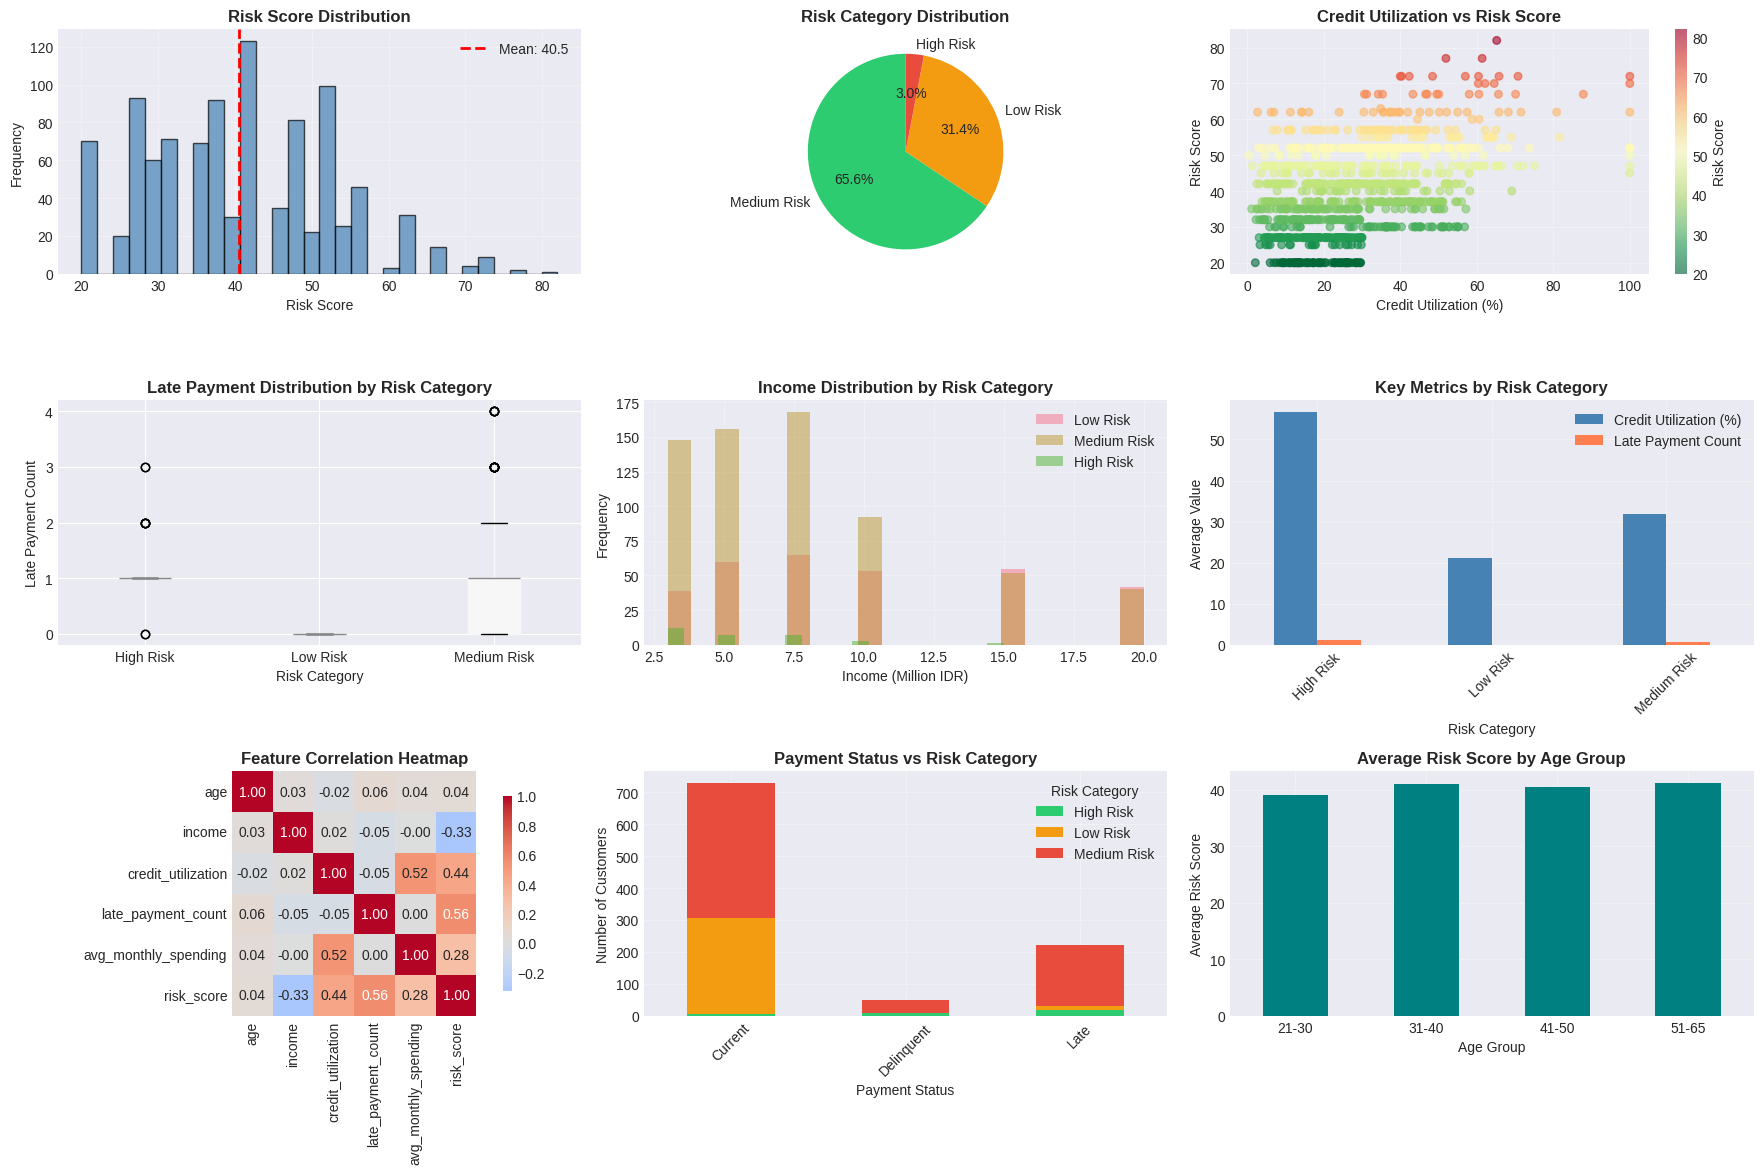


KEY INSIGHTS & RECOMMENDATIONS

1. PORTFOLIO OVERVIEW:
   • Total Customers Analyzed: 1,000
   • High Risk Customers: 30 (3.0%)
   • Average Portfolio Risk Score: 40.50

2. KEY RISK FACTORS:
   • High-risk customers have 56.7% credit utilization vs 21.1% for low-risk
   • Late payment count strongly correlates with risk score
   • Credit utilization is the primary driver of risk

3. RECOMMENDATIONS:
   • Monitor customers with credit utilization >60%
   • Implement early warning system for customers with 2+ late payments
   • Review credit limits for high-risk segments
   • Consider payment reminder programs for medium-risk customers
   • Reward programs for low-risk customers to maintain good behavior

4. NEXT STEPS:
   • Develop automated alert system for high-risk behaviors
   • Create targeted intervention strategies per risk segment
   • Implement quarterly risk score reviews
   • Build predictive model for risk migration patterns

✓ Processed data saved as 'customer_risk_scores.

In [2]:
"""
Customer Risk Scoring Model
Credit Card Customer Risk Assessment Framework

Author: [kaila]
Date: November 2024
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 80)
print("CUSTOMER RISK SCORING MODEL - CREDIT CARD CUSTOMER ASSESSMENT")
print("=" * 80)
print("\n")

# ============================================================================
# STEP 1: GENERATE SYNTHETIC DATA
# ============================================================================
print("STEP 1: Generating Synthetic Dataset...")
print("-" * 80)

np.random.seed(42)
n_customers = 1000

# Generate customer data
data = {
    'customer_id': [f'CUST{str(i).zfill(5)}' for i in range(1, n_customers + 1)],
    'age': np.random.randint(21, 65, n_customers),
    'income': np.random.choice(
        [3000000, 5000000, 7500000, 10000000, 15000000, 20000000],
        n_customers,
        p=[0.20, 0.25, 0.20, 0.15, 0.12, 0.08]
    ),
    'employment_status': np.random.choice(
        ['Employed', 'Self-employed', 'Unemployed'],
        n_customers,
        p=[0.70, 0.25, 0.05]
    ),
    'dependents': np.random.randint(0, 5, n_customers),
    'credit_limit': np.random.choice(
        [5000000, 10000000, 15000000, 25000000, 50000000],
        n_customers,
        p=[0.30, 0.30, 0.20, 0.15, 0.05]
    ),
    'credit_utilization': np.random.beta(2, 5, n_customers) * 100,  # 0-100%
    'avg_monthly_spending': None,  # Will be calculated
    'late_payment_count': np.random.poisson(0.5, n_customers),
    'account_age_months': np.random.randint(6, 120, n_customers),
    'payment_status': np.random.choice(
        ['Current', 'Late', 'Delinquent'],
        n_customers,
        p=[0.75, 0.20, 0.05]
    ),
    'missed_payment_6m': np.random.poisson(0.3, n_customers),
    'full_payment_ratio': np.random.beta(5, 2, n_customers) * 100  # 0-100%
}

df = pd.DataFrame(data)

# Calculate avg_monthly_spending based on credit_utilization
df['avg_monthly_spending'] = (df['credit_limit'] * df['credit_utilization'] / 100).astype(int)

# Add some missing values for data cleaning demonstration (5% missing)
missing_indices = np.random.choice(df.index, size=int(0.05 * len(df)), replace=False)
df.loc[missing_indices, 'income'] = np.nan

# Add some outliers for demonstration
outlier_indices = np.random.choice(df.index, size=10, replace=False)
df.loc[outlier_indices, 'credit_utilization'] = np.random.uniform(150, 200, 10)

print(f"✓ Generated {len(df)} customer records")
print(f"✓ Features: {len(df.columns)} columns")
print(f"✓ Added {len(missing_indices)} missing values for cleaning demo")
print(f"✓ Added {len(outlier_indices)} outliers for cleaning demo")
print("\nDataset Preview:")
print(df.head())
print("\n")

# ============================================================================
# STEP 2: DATA CLEANING
# ============================================================================
print("STEP 2: Data Cleaning & Preprocessing...")
print("-" * 80)

# Check for missing values
print("Missing Values:")
print(df.isnull().sum())
print("\n")

# Handle missing values - fill with median
df['income'].fillna(df['income'].median(), inplace=True)
print("✓ Filled missing income values with median")

# Handle outliers in credit_utilization (cap at 100%)
outliers_before = (df['credit_utilization'] > 100).sum()
df['credit_utilization'] = df['credit_utilization'].clip(upper=100)
print(f"✓ Capped {outliers_before} outliers in credit_utilization to 100%")

# Create derived features
df['debt_to_income'] = (df['avg_monthly_spending'] / df['income'] * 100).round(2)
df['credit_limit_to_income'] = (df['credit_limit'] / df['income']).round(2)
print("✓ Created derived features: debt_to_income, credit_limit_to_income")

# Data validation
print("\n✓ Data Cleaning Complete!")
print(f"Final dataset shape: {df.shape}")
print("\n")

# ============================================================================
# STEP 3: RISK SCORE COMPUTATION
# ============================================================================
print("STEP 3: Computing Risk Scores...")
print("-" * 80)

def calculate_risk_score(row):
    """
    Calculate risk score using weighted scoring system
    Score range: 0-100 (higher = higher risk)
    """
    score = 0

    # 1. Credit Utilization Score (Weight: 25%)
    if row['credit_utilization'] < 30:
        score += 5
    elif row['credit_utilization'] < 60:
        score += 15
    else:
        score += 25

    # 2. Late Payment Count (Weight: 30%)
    if row['late_payment_count'] == 0:
        score += 5
    elif row['late_payment_count'] <= 2:
        score += 20
    else:
        score += 30

    # 3. Income Level (Weight: 15%)
    if row['income'] >= 10000000:
        score += 3
    elif row['income'] >= 5000000:
        score += 10
    else:
        score += 15

    # 4. Payment Status (Weight: 20%)
    if row['payment_status'] == 'Current':
        score += 5
    elif row['payment_status'] == 'Late':
        score += 15
    else:  # Delinquent
        score += 20

    # 5. Missed Payments (Weight: 10%)
    if row['missed_payment_6m'] == 0:
        score += 2
    elif row['missed_payment_6m'] <= 2:
        score += 7
    else:
        score += 10

    return min(score, 100)  # Cap at 100

# Apply risk scoring
df['risk_score'] = df.apply(calculate_risk_score, axis=1)

print("Risk Score Calculation Methodology:")
print("  • Credit Utilization (25%): <30%=5pts, 30-60%=15pts, >60%=25pts")
print("  • Late Payment Count (30%): 0=5pts, 1-2=20pts, >2=30pts")
print("  • Income Level (15%): >10M=3pts, 5-10M=10pts, <5M=15pts")
print("  • Payment Status (20%): Current=5pts, Late=15pts, Delinquent=20pts")
print("  • Missed Payments (10%): 0=2pts, 1-2=7pts, >2=10pts")
print("\n✓ Risk scores calculated for all customers")
print(f"Score Range: {df['risk_score'].min():.0f} - {df['risk_score'].max():.0f}")
print(f"Mean Score: {df['risk_score'].mean():.2f}")
print(f"Median Score: {df['risk_score'].median():.2f}")
print("\n")

# ============================================================================
# STEP 4: RISK SEGMENTATION
# ============================================================================
print("STEP 4: Customer Risk Segmentation...")
print("-" * 80)

def categorize_risk(score):
    """Categorize customers into risk segments"""
    if score <= 33:
        return 'Low Risk'
    elif score <= 66:
        return 'Medium Risk'
    else:
        return 'High Risk'

df['risk_category'] = df['risk_score'].apply(categorize_risk)

# Risk distribution
risk_dist = df['risk_category'].value_counts()
print("Risk Category Distribution:")
for category, count in risk_dist.items():
    percentage = (count / len(df)) * 100
    print(f"  {category:15s}: {count:4d} customers ({percentage:5.2f}%)")

print("\n✓ Customers segmented into 3 risk categories")
print("\n")

# ============================================================================
# STEP 5: STATISTICAL ANALYSIS
# ============================================================================
print("STEP 5: Statistical Analysis by Risk Category...")
print("-" * 80)

# Group statistics
risk_stats = df.groupby('risk_category').agg({
    'age': 'mean',
    'income': 'mean',
    'credit_utilization': 'mean',
    'late_payment_count': 'mean',
    'avg_monthly_spending': 'mean',
    'risk_score': 'mean'
}).round(2)

print("\nAverage Metrics by Risk Category:")
print(risk_stats)
print("\n")

# ============================================================================
# STEP 6: DATA VISUALIZATION
# ============================================================================
print("STEP 6: Creating Visualizations...")
print("-" * 80)

# Create comprehensive visualization dashboard
fig = plt.figure(figsize=(18, 12))
fig.suptitle('Customer Risk Scoring Dashboard - Credit Card Portfolio Analysis',
             fontsize=18, fontweight='bold', y=0.995)

# 1. Risk Score Distribution
ax1 = plt.subplot(3, 3, 1)
plt.hist(df['risk_score'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(df['risk_score'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["risk_score"].mean():.1f}')
plt.xlabel('Risk Score', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.title('Risk Score Distribution', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# 2. Risk Category Pie Chart
ax2 = plt.subplot(3, 3, 2)
colors = ['#2ecc71', '#f39c12', '#e74c3c']  # Green, Yellow, Red
risk_dist.plot(kind='pie', autopct='%1.1f%%', colors=colors, startangle=90)
plt.ylabel('')
plt.title('Risk Category Distribution', fontsize=12, fontweight='bold')

# 3. Credit Utilization vs Risk Score
ax3 = plt.subplot(3, 3, 3)
scatter = plt.scatter(df['credit_utilization'], df['risk_score'],
                     c=df['risk_score'], cmap='RdYlGn_r', alpha=0.6, s=30)
plt.colorbar(scatter, label='Risk Score')
plt.xlabel('Credit Utilization (%)', fontsize=10)
plt.ylabel('Risk Score', fontsize=10)
plt.title('Credit Utilization vs Risk Score', fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)

# 4. Late Payments by Risk Category
ax4 = plt.subplot(3, 3, 4)
df.boxplot(column='late_payment_count', by='risk_category', ax=ax4, patch_artist=True)
plt.xlabel('Risk Category', fontsize=10)
plt.ylabel('Late Payment Count', fontsize=10)
plt.title('Late Payment Distribution by Risk Category', fontsize=12, fontweight='bold')
plt.suptitle('')

# 5. Income Distribution by Risk Category
ax5 = plt.subplot(3, 3, 5)
for category in ['Low Risk', 'Medium Risk', 'High Risk']:
    data = df[df['risk_category'] == category]['income'] / 1000000
    plt.hist(data, alpha=0.5, label=category, bins=20)
plt.xlabel('Income (Million IDR)', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.title('Income Distribution by Risk Category', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# 6. Average Metrics by Risk Category
ax6 = plt.subplot(3, 3, 6)
metrics_df = df.groupby('risk_category')[['credit_utilization', 'late_payment_count']].mean()
metrics_df.plot(kind='bar', ax=ax6, color=['steelblue', 'coral'])
plt.xlabel('Risk Category', fontsize=10)
plt.ylabel('Average Value', fontsize=10)
plt.title('Key Metrics by Risk Category', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.legend(['Credit Utilization (%)', 'Late Payment Count'])
plt.grid(alpha=0.3)

# 7. Correlation Heatmap
ax7 = plt.subplot(3, 3, 7)
corr_features = ['age', 'income', 'credit_utilization', 'late_payment_count',
                 'avg_monthly_spending', 'risk_score']
correlation_matrix = df[corr_features].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, ax=ax7, cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Heatmap', fontsize=12, fontweight='bold')

# 8. Payment Status Distribution
ax8 = plt.subplot(3, 3, 8)
payment_risk = pd.crosstab(df['payment_status'], df['risk_category'])
payment_risk.plot(kind='bar', stacked=True, ax=ax8, color=colors)
plt.xlabel('Payment Status', fontsize=10)
plt.ylabel('Number of Customers', fontsize=10)
plt.title('Payment Status vs Risk Category', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.legend(title='Risk Category')
plt.grid(alpha=0.3)

# 9. Risk Score by Age Group
ax9 = plt.subplot(3, 3, 9)
df['age_group'] = pd.cut(df['age'], bins=[20, 30, 40, 50, 65],
                         labels=['21-30', '31-40', '41-50', '51-65'])
age_risk = df.groupby('age_group')['risk_score'].mean()
age_risk.plot(kind='bar', ax=ax9, color='teal')
plt.xlabel('Age Group', fontsize=10)
plt.ylabel('Average Risk Score', fontsize=10)
plt.title('Average Risk Score by Age Group', fontsize=12, fontweight='bold')
plt.xticks(rotation=0)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('risk_scoring_dashboard.png', dpi=300, bbox_inches='tight')
print("✓ Dashboard saved as 'risk_scoring_dashboard.png'")

plt.show()

# ============================================================================
# STEP 7: KEY INSIGHTS & RECOMMENDATIONS
# ============================================================================
print("\n" + "=" * 80)
print("KEY INSIGHTS & RECOMMENDATIONS")
print("=" * 80)

high_risk_count = len(df[df['risk_category'] == 'High Risk'])
high_risk_pct = (high_risk_count / len(df)) * 100

avg_util_high = df[df['risk_category'] == 'High Risk']['credit_utilization'].mean()
avg_util_low = df[df['risk_category'] == 'Low Risk']['credit_utilization'].mean()

print(f"""
1. PORTFOLIO OVERVIEW:
   • Total Customers Analyzed: {len(df):,}
   • High Risk Customers: {high_risk_count} ({high_risk_pct:.1f}%)
   • Average Portfolio Risk Score: {df['risk_score'].mean():.2f}

2. KEY RISK FACTORS:
   • High-risk customers have {avg_util_high:.1f}% credit utilization vs {avg_util_low:.1f}% for low-risk
   • Late payment count strongly correlates with risk score
   • Credit utilization is the primary driver of risk

3. RECOMMENDATIONS:
   • Monitor customers with credit utilization >60%
   • Implement early warning system for customers with 2+ late payments
   • Review credit limits for high-risk segments
   • Consider payment reminder programs for medium-risk customers
   • Reward programs for low-risk customers to maintain good behavior

4. NEXT STEPS:
   • Develop automated alert system for high-risk behaviors
   • Create targeted intervention strategies per risk segment
   • Implement quarterly risk score reviews
   • Build predictive model for risk migration patterns
""")

# Save processed data
df.to_csv('customer_risk_scores.csv', index=False)
print("✓ Processed data saved as 'customer_risk_scores.csv'")

print("\n" + "=" * 80)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("=" * 80)